# Computation of the rotational bispectrum 

In this companion notebook for the paper _An application of a semidiscrete version of the Petitot model of the human primary visual cortex to invariant object recognition in SVM context_, we present the MATLAB implementation for the computation of the rotational bispectra. 
The computation of the rotational power-spectrum and of the generalized power-spectrum and bispectrum can be easily obtained from this one.

We recall that, following Theorem 3 of the paper, given an image $f:\mathbb R^2\to \mathbb R$, in order to compare the rotational power spectrum, we only need to compute the quantities:
$$
				I_2^{\lambda_1,\lambda_2,h}(f)
				= \langle\omega_{\phi f}(R_h\lambda_1)\odot \omega_{\phi f}(\lambda_2), \omega_{\phi f}(\lambda_1+\lambda_2)\rangle
                =\sum_{k=0}^{N-1} \hat f(R_{-k+h}\lambda_1)\hat f(R_{-k}\lambda_2) \overline{\hat f(R_{-k}(\lambda_1+\lambda_2))}.
$$
In particular, observe that these do not depend on the centering $\phi$ of the image $f$.

## 1. Read the grayscale inpute image

We start by converting the input image to grayscale, with `double` entries in the interval $[0,1]$. 

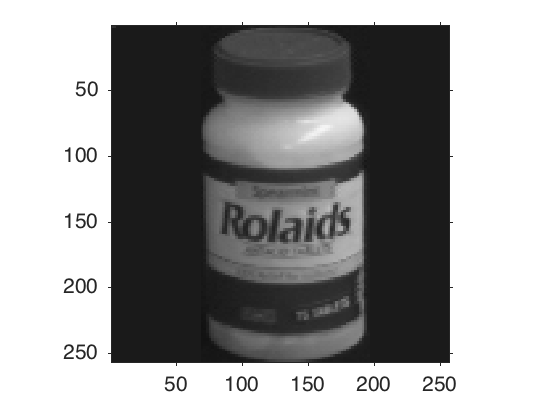

In [1]:
im = imread('image_test.png');

[u,v,z]=size(im);
if z > 1
    im = rgb2gray(im);
end

img = double(imresize(im,[256 256],'nearest'))/255;
%img = barycentre(img);

figure(1)
imshow(img)
axis on

## 2. The shifted Fourier transform of the input image

We compute the normalized Fourier transform of the image and we shift the zero frequency compenent to the center of the spectrum.

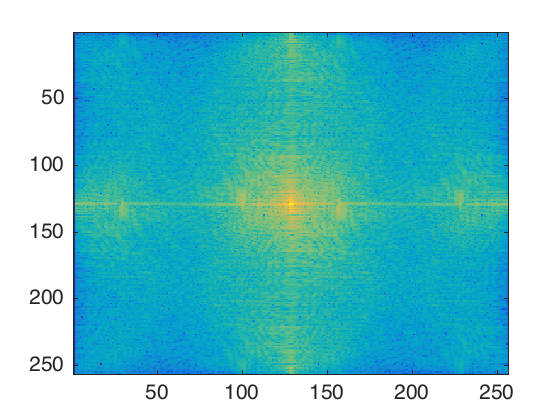

In [2]:
FFT1 = fftshift(fft2(img));
dft1 = FFT1/norm(FFT1);

figure(3)
imagesc(log(abs(dft1)))

## 3. Generation of the hexagonal grid

For cost computational reasons and since we are dealing with natural images, for which the relevant frequencies are the low ones, we extract a regular hexagonal grid of $16\times 16$ pixels around the origin 

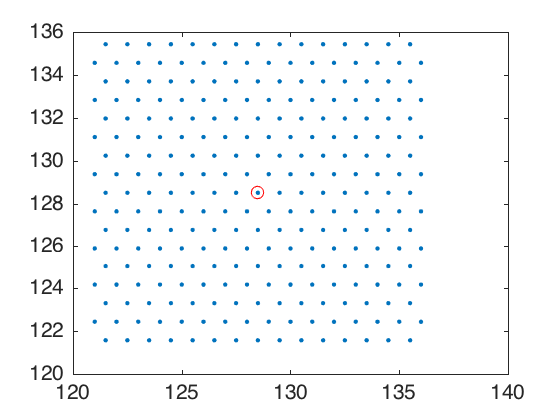

In [3]:
step = 1;
center_xy = (size(img)+1)/2; %center of the image

hex_grid = hexagonal_grid(size(img,1)/16, size(img,2)/16, step);
hex_grid = hex_grid + 15*size(img,1)/32;
center_hex = center_xy/2 + (size(img)+1)/4;%centre maillage

figure(5)
plot(hex_grid(:,1),hex_grid(:,2),'.')  
hold on 
plot(center_hex(1),center_hex(2),'r--o')

The function `hexagon` used in the following section, extracts the coordinates of the six points composing the hexagon around a given center, if they are inside the grid:

```julia
function coords = hexagon(x,y,xc,yc,bornInfx,bornSupx,bornInfy,bornSupy)
    coords = [];
    if(abs(x-xc)>=1) &&  (abs(y-yc)>=1)
        v = [x-xc, y-yc]';

        for theta=0:pi/3:(2*pi-pi/3)
            R = [cos(theta), -sin(theta); sin(theta), cos(theta)];
            vR = R*v;
            p = [xc,yc] + vR';
            p = [p(2),p(1)];
            if(p(2)>bornInfx) && (p(2)<bornSupx) && (p(1)>bornInfy) && (p(1)<bornSupy)
            coords = [coords; p];
            else
                continue
            end
        end
    else
       coords = [1,1]; 
    end
end
```

## 4. Computation of the rotational bispectrum

The invariant are computed from the shifted Fourier transform values,on frequencies selected on a hexagonal grid 
contained in the above and invariant under rotation : 
$$
				I_2^{\lambda_1,\lambda_2,h}(f)
				= \langle\omega_{\phi f}(R_h\lambda_1)\odot \omega_{\phi f}(\lambda_2), \omega_{\phi f}(\lambda_1+\lambda_2)\rangle
                =\sum_{k=0}^{N-1} \hat f(R_{-k+h}\lambda_1)\hat f(R_{-k}\lambda_2) \overline{\hat f(R_{-k}(\lambda_1+\lambda_2))}.
$$
A bilinear interpolation is applied to obtain the correct values of $\omega_f(\lambda)$. The final dimension and a small view of the feature-vector is given at the end of this script.

In [4]:
descriptor = [];
% we extract lambda1 pixels and we extract the associated hexagon foreach lambda1
for j=1:size(hex_grid,1)
    
    lambda1(1)= hex_grid(j,1); %lambda1_coord x
    lambda1(2)= hex_grid(j,2); %lambda1_coord y

    orbitf11 = hexagon(lambda1(1),lambda1(2),center_hex(1),center_hex(2),...
                15*size(img,1)/32,17*size(img,1)/32, 15*size(img,2)/32,17*size(img,2)/32);
    
    % we verify if we have a complete hexagon
    if(size(orbitf11,1)==6)             
        orbitf1 = orbitf11;      
    else 
        orbitf1 = zeros(6,2);        
    end
    
%  we fix lambda1, we extract lambda2 and we extract the associated hexagon foreach lambda2 and lambda3 = lambda1+lambda2
    for i=1:size(hex_grid,1)
        lambda2(1)= hex_grid(i,1); %lambda2_coord x
        lambda2(2)= hex_grid(i,2); %lambda2_coord y
                       
        u1 = hexagon(lambda2(1),lambda2(2),center_hex(1),center_hex(2),...
                15*size(img,1)/32,17*size(img,1)/32, 15*size(img,2)/32,17*size(img,2)/32);

        % lambda3 should not exceed the hexagonal grid boundary
        v1 = hexagon(lambda2(1),lambda2(2),lambda1(1),lambda1(2),...
                15*size(img,1)/32,17*size(img,1)/32, 15*size(img,2)/32,17*size(img,2)/32);
        
        % we verify if we have a complete hexagon
        if(size(u1,1)==6 && size(v1,1)==6)

            u = u1;  
            %we extract hexagon foreach lambda2 and lambda3 with respect to 6 rotations
            for N=1:6
                % If we want to compute the generalized bispectrum invariant, then we can fix N=6
                orbitf2 = circshift(u,N);
                x = hexagon(v1(N,1),v1(N,2),center_hex(1),center_hex(2),...
                        15*size(img,1)/32,17*size(img,1)/32, 15*size(img,2)/32,17*size(img,2)/32);
            
                if(size(x,1)==6)
                    orbitf3 = x;
                else
                    orbitf3 = zeros(6,2);
                end

                % to evaluate the Fourier transform of the image on each extracted hexagon orbitf1, orbit2&3
                % we apply a bilinear interpolation to obtain the correct value of omegaf1,omegaf2 and omegaf3
                if( sum(sum(orbitf1))~=0 && sum(sum(orbitf2))~=0 && sum(sum(orbitf3))~=0)
                    for t=1:size(orbitf1,1)
                        x1 = orbitf3(t,1); y1 = orbitf3(t,2);
                        x2 = orbitf1(t,1); y2 = orbitf1(t,2);
                        x3 = orbitf2(t,1); y3 = orbitf2(t,2);            

                        a(t) = dft1(floor(x1),floor(y1)) + (x1-floor(x1)) * (dft1(floor(x1)+1,floor(y1)) - dft1(floor(x1),floor(y1)))...
                                + (y1 - floor(y1)) * (dft1(floor(x1),floor(y1)+1) - dft1(floor(x1),floor(y1)));                                                        

                        b(t) = dft1(floor(x2),floor(y2)) + (x2-floor(x2)) * (dft1(floor(x2)+1,floor(y2)) - dft1(floor(x2),floor(y2)))...
                                + (y2 - floor(y2)) * (dft1(floor(x2),floor(y2)+1) - dft1(floor(x2),floor(y2)));

                        c(t) = dft1(floor(x3),floor(y3)) + (x3-floor(x3)) * (dft1(floor(x3)+1,floor(y3)) - dft1(floor(x3),floor(y3)))...
                                + (y3 - floor(y3)) * (dft1(floor(x3),floor(y3)+1) - dft1(floor(x3),floor(y3)));
                    end
                    omegaf3 = a';
                    omegaf1 = b';
                    omegaf2 = c';

                    If = omegaf3 .* conj(omegaf1 .* omegaf2);
                else
                    continue;
                    fprintf(1,'hexagonal grid boundary exceeded\n');
                end

                invariant = sum(If);
                descriptor = [descriptor; invariant];
            end
        else
            u1 = zeros(6,2);  
            v1 = zeros(6,2);
        end
    end
end

In [5]:
descriptor_size = size(descriptor)
small_view = descriptor(1:10,1)

descriptor_size =

        4474           1


small_view =

   1.0e-04 *

  -0.0034 - 0.0164i
  -0.1401 + 0.0649i
  -0.0436 + 0.0265i
   0.0098 - 0.0329i
  -0.0436 + 0.0863i
   0.0790 - 0.0773i
   0.2083 + 0.0069i
   0.0274 + 0.0172i
   0.1677 + 0.0525i
   0.0035 - 0.0714i
